# PET simulation analysis

Run the simulation with `Gate mac/main.mac`

The output will be the files `output/pet2-Singles.root`, `output/pet2-Coincidences.root`

Vocabulary:
- events: (Geant4) primary particle tracked by the MC engine (source)
- track: (Geant4) every tracked particle is a track (including primary and secondaries)
- step: (Geant4) tracking is divided in step
- hits: (Gate) individual interaction inside a detector (with energy deposition)
- singles: combined hits in a given element (i.e. a single detector)
- coincidences: time associated singles
- trues: real, expected coincidences
- randoms: accidental coincidence
- scatters: coincidence events resulting from scattered photons inside the phantom
- prompts: total number of detected coincidences (sum of Trues + Randoms + Scatters)
- delays: estimated number of scattered coincidence

In [19]:
# some functions are defined in the file called pet_helpers.py
# they will be available with p.function_name()
# Example: 
import pet_helpers as p
p.hello()

Hello World


In [20]:
import os
from pathlib import Path
# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
#folder = Path(os.path.join(cwd, '../output.3M.events'))
folder = Path(os.path.join(cwd, './output'))
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /home/jovyan/work
The output folder is /home/jovyan/work/output


In [21]:
# print information about the simulation by reading the stat.txt file
stat = os.path.join(folder, 'stat.txt')
fs = open(stat, 'r').read()
n_events = int(p.get_stat_value(fs, '# NumberOfEvents = '))
t_start = int(p.get_stat_value(fs, '# StartSimulationTime        = '))
t_stop = int(p.get_stat_value(fs, '# StopSimulationTime         = '))
print(f'Number of simulated events (primaries): {n_events}')
print(f'Simulation timing: {t_start} to {t_stop} seconds')

Number of simulated events (primaries): 423
Simulation timing: 0 to 0 seconds


In [22]:
# opening the files
import uproot
def read_root_tree(filename):
    filename = os.path.join(folder, filename)
    f = uproot.open(filename)
    t = f[b'tree']
    print(f'Reading file {filename}')
    return t

The content of this root file is a set of data, organized in keys. For example, you can retrive all the particles information of the 'Singles' or of the 'Coincidences'.

In [16]:
hits = read_root_tree('pet2.hits.root')
singles = read_root_tree('pet2.Singles.root')
coinc = read_root_tree('pet2.Coincidences.root')
delays = read_root_tree('pet2.delay.root')

Reading file /home/jovyan/work/output/pet2.hits.root
Reading file /home/jovyan/work/output/pet2.Singles.root
Reading file /home/jovyan/work/output/pet2.Coincidences.root
Reading file /home/jovyan/work/output/pet2.delay.root


# Info: print the hits/singles/coincidences etc

In [17]:
# in the initial simulation the hits are not stored. 
# It can be enabled with the following macro:
# /gate/output/root/setRootHitFlag 1 in the file output.mac
# warning : it lead to a very large output file
print('Number of hits:', len(hits))
print('Number of singles:', len(singles))
print('Number of coincidences:', len(coinc))
print('Number of delays', len(delays))
print('Singles keys: ')
for i in singles.keys():
    print(i, ' ', end='')

Number of hits: 441
Number of singles: 114
Number of coincidences: 0
Number of delays 0
Singles keys: 
b'runID'  b'eventID'  b'sourceID'  b'sourcePosX'  b'sourcePosY'  b'sourcePosZ'  b'globalPosX'  b'globalPosY'  b'globalPosZ'  b'gantryID'  b'rsectorID'  b'moduleID'  b'submoduleID'  b'crystalID'  b'layerID'  b'time'  b'energy'  b'comptonPhantom'  b'comptonCrystal'  b'RayleighPhantom'  b'RayleighCrystal'  b'comptVolName'  b'RayleighVolName'  b'rotationAngle'  b'axialPos'  

In [18]:
# Counts
# Cscat : scatter counts is the number of falsely located coincidence events resulting from gamma rays scattering inside the phantom
# Ctrue : is the number of true coincidences
# Crnd  : the number of random (accidental) coincidences
# Ctot  : Ctot = Cscat + Ctrue + Crnd is the total number of detected coincidences, sometimes called 'prompts'
# The 'delays' are the number of estimated random (because the real number of randoms cannot be known on a real system)
trues, scatters, randoms, Ctot = p.get_counts(coinc)
absolute_sensitivity = len(trues)/n_events
print(f'Number of detected coincidences  Ctot   {Ctot} ')
print(f'Number of scattered coincidences Cscat  {len(scatters)} ')
print(f'Number of true coincidences      Ctrue  {len(trues)} ')
print(f'Number of random coincidences    Crnd   {len(randoms)} ')
print(f'Number of estimated random       Delays {len(delays)}')
print(f'Absolute sensibility (Ctrues/events)    {absolute_sensitivity*100:.2f} %')

Number of detected coincidences  Ctot   0 
Number of scattered coincidences Cscat  0 
Number of true coincidences      Ctrue  0 
Number of random coincidences    Crnd   0 
Number of estimated random       Delays 0
Absolute sensibility (Ctrues/events)    0.00 %


# Plot some information about the detection

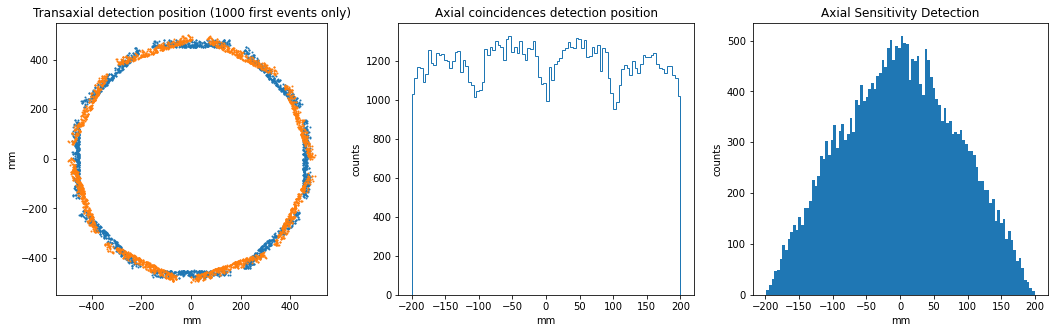

In [8]:
# plot1
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
slice_time = 100
p.plot_transaxial_position(ax[0], coinc, slice_time)
p.plot_axial_detection(ax[1], coinc)
p.plot_axial_sensitivity_detection(ax[2], trues)

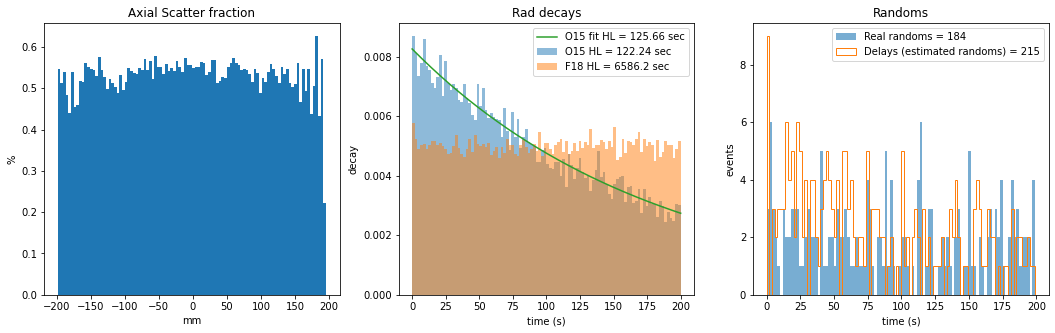

In [39]:
# plot2
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
p.plot_axial_scatter_fraction(ax[0], coinc, scatters)
decayF18, decayO15 = p.get_decays(coinc)
p.plot_rad_decay(ax[1], t_stop, decayO15, decayF18)
p.plot_randoms_delays(ax[2], randoms, delays)

# Plot the energy  of the singles

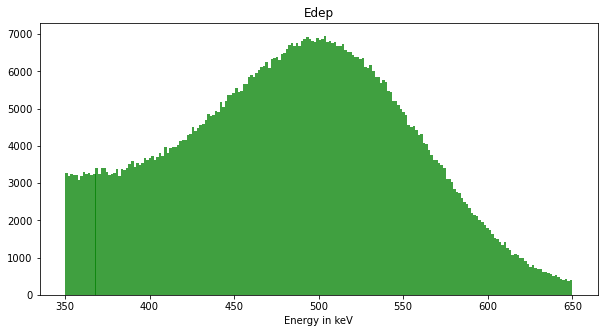

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
energy = singles.arrays()[b'energy']/0.001
n, bins, patches = ax.hist(energy, 200, facecolor='green', alpha=0.75)
ax.set_title('Edep')
ax.set_xlabel('Energy in keV');

# Plot some LOR (Line Of Responses)

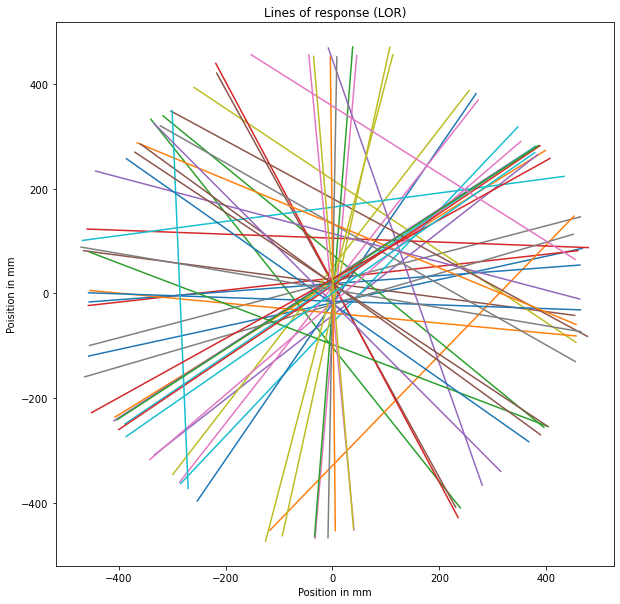

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
p.plot_LOR(ax, coinc, 50)